In [ ]:
import findspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, year, month, count, desc, asc, round, countDistinct, sum, quarter, format_number, concat, lit, lag, when

import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np

In [2]:
findspark.init()

spark = SparkSession.builder \
    .appName("Data Analysis") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.extraClassPath", r"C:\Drivers\sqljdbc_12.10.0.0_enu\sqljdbc_12.10\enu\jars\mssql-jdbc-12.10.0.jre11.jar") \
    .getOrCreate()

# Read CSV
customers = spark.read.csv(
    "../final data/customer_features.csv",
    header=True,
    inferSchema=True,
    sep=",",
    quote='"',
    escape='"',
    multiLine=True  
)

orders = spark.read.csv(
    "../final data/orders_facts.csv",
    header=True, 
    inferSchema=True, 
    sep=",",
    quote='"',
    escape='"',
    multiLine=True
)

region = spark.read.csv(
    "../final data/region_dim.csv", 
    header=True, 
    inferSchema=True
)

product = spark.read.csv(
    "../final data/product_dim.csv", 
    header=True, 
    inferSchema=True
)


# Get to Know Your Customers First: Build Complete Customer Profiles

In [3]:
customers.show()

+-----------+-------------------+------------------+---------------+---------------------+-----------------------+----------------------------+-----------------------+------------------------+----------------------+------------------+--------------------------+--------------------------------+---------------------+---------------------+----------------------------------+--------------------------+----------------+-----------------------+---------------------+-----------------+--------------------------+--------------------------+---------------------------+
|customer_id|customer_first_date|customer_last_date|customer_tenure|customer_no_of_orders|customer_total_quantity|customer_average_order_value|customer_historical_clv|customer_diversity_score|customer_total_revenue|customer_is_repeat|customer_churn_probability|customer_avg_days_between_orders|customer_return_count|customer_return_value|customer_first_order_product_count|customer_first_order_value|customer_recency|customer_shipment_c

In [4]:
customers = customers \
    .withColumn("first_year", year(col("customer_first_date"))) \
    .withColumn("first_month", month(col("customer_first_date")))


#### How many new customers am I acquiring each  year and month?

In [5]:
customers.select("customer_id", "first_year") \
    .groupBy("first_year") \
    .agg(count("customer_id").alias("customer_count")) \
    .orderBy(asc("first_year")) \
    .show()

+----------+--------------+
|first_year|customer_count|
+----------+--------------+
|      2010|          1130|
|      2011|           714|
|      2012|           462|
|      2013|           397|
+----------+--------------+



In [6]:
customers.select("customer_id", "first_year", "first_month") \
    .groupBy("first_year", "first_month") \
    .agg(count("customer_id").alias("customer_count")) \
    .orderBy(asc("first_year"), asc("first_month")) \
    .show()

+----------+-----------+--------------+
|first_year|first_month|customer_count|
+----------+-----------+--------------+
|      2010|          1|           141|
|      2010|          2|            96|
|      2010|          3|           125|
|      2010|          4|           105|
|      2010|          5|           103|
|      2010|          6|            84|
|      2010|          7|            92|
|      2010|          8|            89|
|      2010|          9|            74|
|      2010|         10|            77|
|      2010|         11|            74|
|      2010|         12|            70|
|      2011|          1|            74|
|      2011|          2|            64|
|      2011|          3|            62|
|      2011|          4|            53|
|      2011|          5|            74|
|      2011|          6|            60|
|      2011|          7|            56|
|      2011|          8|            49|
+----------+-----------+--------------+
only showing top 20 rows



# What is our true cost ot acquire new customers? 

Since we don't have the marketing and expenses data we cannot get the answer to that, however for now we are losing money in discounts trying to acquire customers and retain customers so we might as well use the discount to know how much on average we are losing because of that.

In [7]:
orders\
.join(
    customers, "customer_id"
).withColumn(
    "order_year", year("order_date")
).filter(
    col("order_year") == col("first_year")
).select(
    "customer_id", 
    "discount_amount", 
    "first_year"
).groupBy(
    "first_year"
).agg(
    round(sum("discount_amount"), 2).alias("total_discount_spend"), 
    countDistinct("customer_id").alias("new_customers"), 
    round((sum("discount_amount") / countDistinct("customer_id")), 2).alias("discount_per_customer")
).orderBy(
    asc("first_year")
).show()

+----------+--------------------+-------------+---------------------+
|first_year|total_discount_spend|new_customers|discount_per_customer|
+----------+--------------------+-------------+---------------------+
|      2010|            10230.78|         1130|                 9.05|
|      2011|             4421.12|          714|                 6.19|
|      2012|              2736.7|          462|                 5.92|
|      2013|             3288.64|          397|                 8.28|
+----------+--------------------+-------------+---------------------+



We have the drop in discount per customer in the year 2011 and 2012 possibly due to correct targeting or higher organic growth (less reliance on discounts). A rising discount per customer amount in 2013 can leave us with question of whether their is increasing competition or if discounts were not as effective.

Possible steps 
1. Repeat purchases (Cohort analysis)
* % of discounted customers who made a 2nd purchase 
* If the retition is low, discounts may not be worth it. (how low is low)

####  What is my revenue per customer? How is it trending?

In [8]:
orders\
.join(
    customers, "customer_id"
).select(
    "customer_id", 
    "total_price", 
    "order_date"
).groupBy(
    year(col("order_date"))
).agg(
    round(sum("total_price"), 2).alias("total_revenue"), 
    countDistinct("customer_id").alias("customers"), 
    round((sum("total_price") / countDistinct("customer_id")), 2).alias("total_revenue_per_customer")
).orderBy(
    asc(year(col("order_date")))
).show()

+----------------+-------------+---------+--------------------------+
|year(order_date)|total_revenue|customers|total_revenue_per_customer|
+----------------+-------------+---------+--------------------------+
|            2010|   1890156.31|     1130|                    1672.7|
|            2011|   1921968.12|     1213|                   1584.47|
|            2012|   2209445.78|     1232|                   1793.38|
|            2013|   2828033.35|     1589|                   1779.76|
+----------------+-------------+---------+--------------------------+



Revenue per customer has been increasing for different reasons except for 2011 
* the customer are just increasing their spending with us 
* we acquired new high spending customers 
* we introduced products that were favoured by customers 

#### How seasonal are my revenue and margin?

In [9]:
orders = orders \
.withColumn(
    "order_quarter", quarter(col("order_date")), 
).withColumn(
    "order_year", year(col("order_date"))
).withColumn(
    "order_month", month(col("order_date"))
)

orders.show(2)

+--------------+--------+-----------+----------+---------+------------+----------+----------+--------+----------+---------------+--------------+-------------+--------+-----------+---------+-------------+----------+-----------+
|order_fact_key|order_id|customer_id|product_id|region_id|ship_mode_id|order_date| ship_date|discount|unit_price|discount_amount|discount_price|shipping_cost|quantity|total_price|is_return|order_quarter|order_year|order_month|
+--------------+--------+-----------+----------+---------+------------+----------+----------+--------+----------+---------------+--------------+-------------+--------+-----------+---------+-------------+----------+-----------+
|             1|   88525|          2|       179|        1|           3|2012-05-28|2012-05-30|    0.01|      2.88|           0.03|          2.85|          0.5|       2|        5.7|    false|            2|      2012|          5|
|             2|   88522|          3|       924|     1659|           2|2010-07-07|2010-07-08

In [10]:
quarterly_revenue = orders.select(
    "total_price", 
    "order_quarter", 
    "order_year"
).groupBy(
    "order_year", "order_quarter"
).agg(
    round(sum("total_price"), 2).alias("total_revenue_raw")
).orderBy(
    asc("order_year"), 
    asc("order_quarter")
)

window = Window.orderBy("order_year", "order_quarter")
quarterly_growth = quarterly_revenue.withColumn(
    "prev_quarter_revenue", 
    lag("total_revenue_raw").over(window)
).withColumn(
    "revenue_growth_pct", 
    when(
        col("prev_quarter_revenue").isNull(), 
        lit(0)
    ).otherwise(
        ((col("total_revenue_raw") - col("prev_quarter_revenue")) / col("prev_quarter_revenue")) * 100
    )
)

final_result = quarterly_growth.select(
    "order_year",
    "order_quarter",
    concat(lit("$"), format_number("total_revenue_raw", 2)).alias("total_revenue"),
    concat(
        round("revenue_growth_pct", 2), 
        lit("%")
    ).alias("growth_pct")
).orderBy(
    asc("order_year"), 
    asc("order_quarter")
)

final_result.show()

+----------+-------------+-------------+----------+
|order_year|order_quarter|total_revenue|growth_pct|
+----------+-------------+-------------+----------+
|      2010|            1|  $406,683.52|      0.0%|
|      2010|            2|  $342,842.92|    -15.7%|
|      2010|            3|  $460,035.27|    34.18%|
|      2010|            4|  $680,594.60|    47.94%|
|      2011|            1|  $265,598.30|   -60.98%|
|      2011|            2|  $337,932.41|    27.23%|
|      2011|            3|  $540,158.91|    59.84%|
|      2011|            4|  $778,278.50|    44.08%|
|      2012|            1|  $290,417.35|   -62.68%|
|      2012|            2|  $429,894.96|    48.03%|
|      2012|            3|  $497,909.34|    15.82%|
|      2012|            4|  $991,224.13|    99.08%|
|      2013|            1|  $532,774.77|   -46.25%|
|      2013|            2|  $518,723.23|    -2.64%|
|      2013|            3|  $718,206.97|    38.46%|
|      2013|            4|$1,058,328.38|    47.36%|
+----------+

Strong seasonality exists with Q4 being consistently the strongest quarter and Q1 being consistently the weakest with the exception of 2010. Every year, without fail, **Q4 emerges as the best**, delivering the highest revenue by a wide margin. The numbers don't lie, 2010 Q4: $680K -> 2013 Q4: $1.05 (a 55% increases in just 3 years) mostly likely due to holiday effect. After the Q4 high, Q1 stumbles a universal truth in retail. 2011 Q1: A dismal -61% drop from 2010 Q4. 2013 Q1: Despite being the strongest Q1 ($532K), it still fell -46% from the prior Q4.
This isn’t just a dip it’s a systemic challenge. Customers tighten budgets after splurging in Q4.

#### Is most of my revenue coming from new or repeat buyers

In [11]:
from pyspark.sql.functions import col, sum, asc

# Calculate new customer revenue (first-time purchasers)
new_customers_df = orders.join(
    customers, "customer_id"
).select(
    "customer_id", 
    "first_year", 
    "total_price",
    "order_year"
).filter(
    col("first_year") == col("order_year")
).groupBy(
    "order_year"
).agg(
    sum("total_price").alias("new_customer_revenue"),
    countDistinct("customer_id").alias("new_customer_count")
)

# Calculate returning customer revenue
old_customers_df = orders.join(
    customers, "customer_id"
).select(
    "customer_id", 
    "first_year", 
    "total_price",
    "order_year"
).filter(
    col("first_year") < col("order_year")
).groupBy(
    "order_year"
).agg(
    sum("total_price").alias("returning_customer_revenue"),
    countDistinct("customer_id").alias("returning_customer_count")
)

# Join and calculate metrics
cohort_analysis = new_customers_df.join(
    old_customers_df, "order_year", "outer"
).orderBy(asc("order_year"))

# Calculate percentages and averages
cohort_analysis = cohort_analysis.withColumn(
    "total_revenue",
    col("new_customer_revenue") + col("returning_customer_revenue")
).withColumn(
    "returning_revenue_pct",
    (col("returning_customer_revenue") / col("total_revenue")) * 100
).withColumn(
    "avg_new_customer_value",
    col("new_customer_revenue") / col("new_customer_count")
).withColumn(
    "avg_returning_customer_value",
    col("returning_customer_revenue") / col("returning_customer_count")
)

# Show comprehensive results
cohort_analysis.show()

+----------+--------------------+------------------+--------------------------+------------------------+------------------+---------------------+----------------------+----------------------------+
|order_year|new_customer_revenue|new_customer_count|returning_customer_revenue|returning_customer_count|     total_revenue|returning_revenue_pct|avg_new_customer_value|avg_returning_customer_value|
+----------+--------------------+------------------+--------------------------+------------------------+------------------+---------------------+----------------------+----------------------------+
|      2010|  1890156.3099999991|              1130|                      NULL|                    NULL|              NULL|                 NULL|    1672.7046991150435|                        NULL|
|      2011|           912339.29|               714|        1009628.8299999993|                     499|1921968.1199999992|   52.530987350612236|    1277.7861204481794|          2023.3042685370726|
|      201

#### What is my annual total number of orders of products shipped?   

In [12]:
orders.select(
    "order_year", 
    "order_id",
    "customer_id"
).groupBy(
    "order_year"
).agg(
    countDistinct("order_id").alias("no_of_orders"),
    countDistinct("customer_id").alias("no_of_customers")
).withColumn(
    "orders_per_customer", 
    round(col("no_of_orders") / col("no_of_customers"), 2)
).orderBy(
    "order_year"
).show()

+----------+------------+---------------+-------------------+
|order_year|no_of_orders|no_of_customers|orders_per_customer|
+----------+------------+---------------+-------------------+
|      2010|        1365|           1130|               1.21|
|      2011|        1454|           1213|                1.2|
|      2012|        1487|           1232|               1.21|
|      2013|        2185|           1589|               1.38|
+----------+------------+---------------+-------------------+



#### What is the order value by month, do some months see larger deals

In [13]:
order_value = orders.select(
    "order_id",
    "order_month",
    "order_year", 
    "total_price"
).groupBy(
    "order_year", 
    "order_month"
).agg(
    sum("total_price").alias("total_revenue"), 
    countDistinct("order_id").alias("no_of_orders"),
).withColumn(
    "order_value", 
    round(col("total_revenue") / col("no_of_orders"), 2)
).withColumn(
    "year-month", 
    concat(col("order_year"), lit("-"), col("order_month"))
).orderBy(
    asc("order_year"), 
    asc("order_month")
)

order_value.show()

+----------+-----------+------------------+------------+-----------+----------+
|order_year|order_month|     total_revenue|no_of_orders|order_value|year-month|
+----------+-----------+------------------+------------+-----------+----------+
|      2010|          1|         135440.93|         128|    1058.13|    2010-1|
|      2010|          2|128778.31000000001|         100|    1287.78|    2010-2|
|      2010|          3|142464.27999999997|         126|    1130.67|    2010-3|
|      2010|          4|127861.10999999997|         120|    1065.51|    2010-4|
|      2010|          5| 91282.94999999998|         113|     807.81|    2010-5|
|      2010|          6|123698.85999999999|         102|    1212.73|    2010-6|
|      2010|          7|133564.68999999997|         121|    1103.84|    2010-7|
|      2010|          8|199986.27999999997|         125|    1599.89|    2010-8|
|      2010|          9|126484.29999999996|         111|     1139.5|    2010-9|
|      2010|         10|253669.979999999

In [14]:
order_value_pd = order_value.toPandas()

order_value_pd['date'] = pd.to_datetime(
    order_value_pd['order_year'].astype(str) + '-' + 
    order_value_pd['order_month'].astype(str), 
    format='%Y-%m'
)

order_value_pd = order_value_pd.sort_values('date')

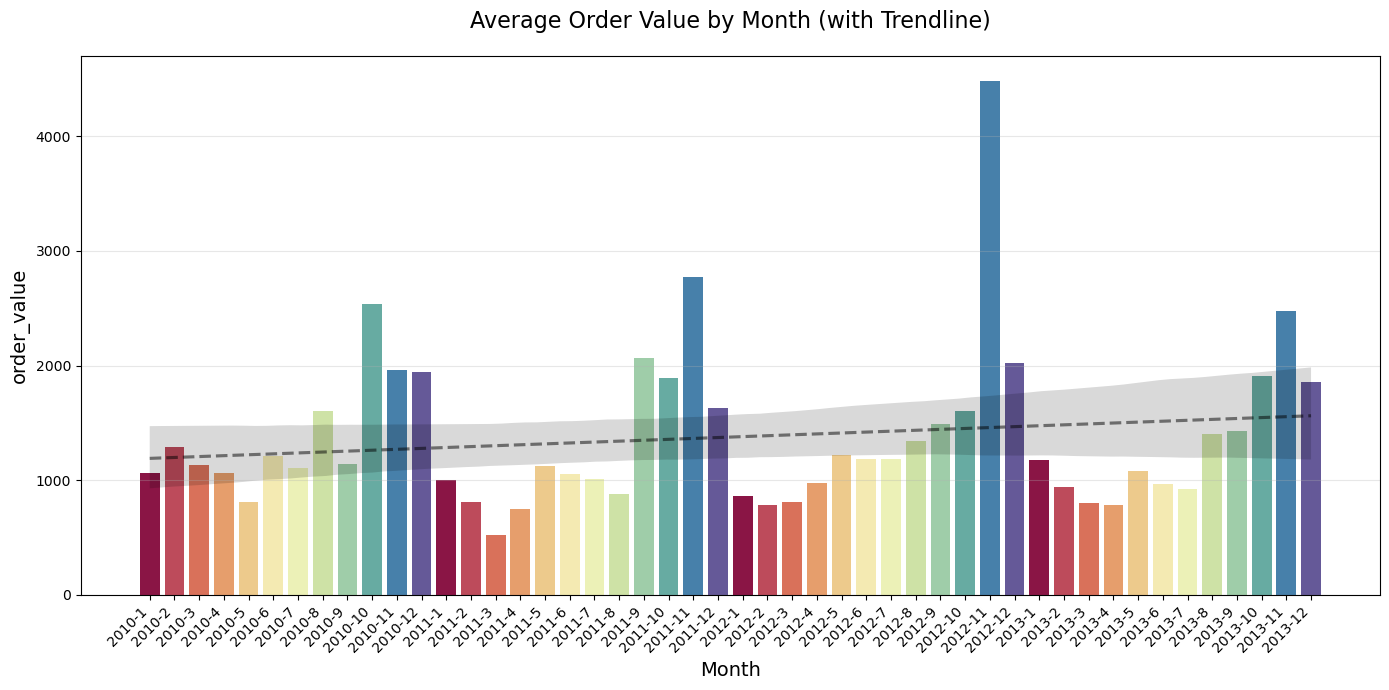

In [15]:
# Create the plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=order_value_pd,
    x="year-month",
    y="order_value",
    hue="order_month",  
    palette="Spectral", 
    dodge=False, 
    legend=False
)

# Customize the plot
plt.title("Average Order Value by Month (with Trendline)", fontsize=16, pad=20)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Avg. Order Value ($)", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for readability

# Add a trendline
x_numeric = pd.factorize(order_value_pd['year-month'])[0]
sns.regplot(
    x=x_numeric,
    y=order_value_pd['order_value'],
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'alpha': 0.5},
    ax=ax
)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### What is my annual average order value and how is it trending over time?

In [16]:
order_value = orders.select(
    "order_id",
    "order_year", 
    "total_price"
).groupBy(
    "order_year", 
).agg(
    sum("total_price").alias("total_revenue"), 
    countDistinct("order_id").alias("no_of_orders")
).withColumn(
    "order_value", 
    round(col("total_revenue") / col("no_of_orders"), 2)
).orderBy(
    asc("order_year"), 
)

order_value.show()

+----------+------------------+------------+-----------+
|order_year|     total_revenue|no_of_orders|order_value|
+----------+------------------+------------+-----------+
|      2010|1890156.3099999996|        1365|    1384.73|
|      2011|1921968.1200000024|        1454|    1321.85|
|      2012|2209445.7799999984|        1487|    1485.84|
|      2013| 2828033.350000003|        2185|    1294.29|
+----------+------------------+------------+-----------+



In [17]:
region.orderBy(desc("avg_order_value")).show()

+---------+-------+--------------------+-------------+-----------+-------------+---------------+--------------------+------------+-----------+-----------+---------------+
|region_id| region|   state_or_province|         city|postal_code|total_revenue|total_customers|revenue_per_customer|total_orders|order_value|return_rate|avg_order_value|
+---------+-------+--------------------+-------------+-----------+-------------+---------------+--------------------+------------+-----------+-----------+---------------+
|      535|   East|District of Columbia|   Washington|      20012|     78561.71|              1|            78561.71|           4|       NULL|       25.0|       19640.43|
|     1468|   West|          California|  Los Angeles|      90061|    121549.21|              1|           121549.21|           8|       NULL|       50.0|       15193.65|
|      884|   East|            New York|New York City|      10165|     84693.31|              1|            84693.31|           6|       NULL|   

* Washington, DC ($19,640) with only 4 orders, suggesting premium purchases. 
* West vs. East Dominance: 3 of the top 5 cities are from the West/East regions.

In [ ]:
orders.join(
    product, 
    "product_id"
).select(
    "customer_id", 
    "product_id", 
    "product_category", 
    "total_price", 
    "order_year"
).groupBy(
    "product_category", 
    "order_year"
).agg(
    countDistinct("customer_id").alias("no_of_customers"), 
    sum("total_price").alias("total_revenue")
).withColumn(
    "order_value", 
    round(col("total_revenue") / col("no_of_customers"), 2)
).orderBy(
    asc("product_category"),
    asc("order_year")
).show()

+----------------+----------+---------------+------------------+-----------+
|product_category|order_year|no_of_customers|     total_revenue|order_value|
+----------------+----------+---------------+------------------+-----------+
|       Furniture|      2010|            348| 632110.3700000002|    1816.41|
|       Furniture|      2011|            379| 661434.8799999994|    1745.21|
|       Furniture|      2012|            392| 921793.6800000004|    2351.51|
|       Furniture|      2013|            523|         873347.47|    1669.88|
| Office Supplies|      2010|            768| 527871.4799999997|     687.33|
| Office Supplies|      2011|            828| 419013.5900000001|     506.06|
| Office Supplies|      2012|            852|497025.13000000035|     583.36|
| Office Supplies|      2013|           1122| 712307.2800000004|     634.85|
|      Technology|      2010|            417| 730174.4600000007|    1751.02|
|      Technology|      2011|            464| 841519.6500000005|    1813.62|

#### **Furniture**

* Steady increase in the number of customers, with a notable jump in 2013 (523 vs. 392 in 2012).
* However, **average order value (AOV)** dropped significantly in 2013 to **\$1,669.88**, the lowest across all years for this category.
* This divergence suggests a **potential shift to budget-friendly furniture** or **increased promotional discounting** in 2013.
* **Action:** Investigate product mix changes and marketing strategies in 2013. Analyze whether the volume growth was driven by lower-margin products.

#### **Office Supplies**

* Strong and **steady customer base growth**, peaking at 1,122 in 2013.
* Despite this, **total revenue declined** from 2010 to 2011 and then rebounded—indicating inconsistent revenue generation relative to customer growth.
* The **2010 cohort had the highest AOV at \$687.33**, suggesting **high-value customers** early on.
* AOV dropped in 2011 and remained lower, possibly due to:

  * Loss of large customers.
  * A shift toward **lower-priced or commoditized items**.
* **Action:**

  * Re-engage top customers from 2010.
  * Analyze whether **cheaper SKUs dominated sales** post-2010.
  * Understand what changed in 2011 to better retain premium accounts.

#### **Technology**

* Consistent growth in customers (from 417 in 2010 to 628 in 2013), though **2012 dipped slightly** to 450.
* This category shows the **highest revenue per customer**:

  * 2013 saw a **70% revenue jump to \$1.24M**, with an **AOV of \$1,978.31** —the **highest among all** entries with the exception of (Furniture 2012)
* Indicates a **premium, high-margin product base**.
* **Action:**

  * Analyze what drove the 2013 surge (new product lines, marketing push?).
  * Leverage success by **upselling warranties, accessories**, and **post-sale services**.
  * Use insights to replicate success in slower years (e.g., 2012).

### **General Insights**

* **Office Supplies** had the most customers but also the lowest AOV, which aligns with its **commodity-like nature**.
* **Technology** outperforms in revenue despite a smaller customer base due to **high-ticket products**.
* **Furniture** had an **inconsistent AOV trend**, which may need closer review of product and pricing strategies.




In [27]:
# Filter customers with avg_discount_rate = 0 and count them
zero_discount_customers = customers.filter(col("avg_discount_rate") == 0)
zero_discount_count = zero_discount_customers.count()

# Get total customer count for comparison
total_customers = customers.count()

# Calculate percentage
percentage_zero_discount = (zero_discount_count / total_customers) * 100

print(f"Customers with 0% discounts: {zero_discount_count} ({percentage_zero_discount:.2f}% of total)")

Customers with 0% discounts: 78 (2.89% of total)


In [32]:
frequent_buyers = customers.filter(col("customer_is_repeat") == True)
print(f"Repeat customers: {frequent_buyers.count()} ({(frequent_buyers.count() / total_customers) * 100:.2f}% of total)")

Repeat customers: 1676 (62.01% of total)
